In [20]:
import os
from dotenv import find_dotenv, load_dotenv
from shapely.ops import orient

load_dotenv(find_dotenv())
src_path = os.environ.get("PROJECT_SRC")
os.chdir(src_path)

src_path

'C:\\Programming\\PyPSA-GB_2030\\PyPSA-GB'

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import generators
from data_reader_writer import data_writer

# Costing Analysis of 2030 Generation

In [22]:
year = 2030
FES_scenario = "Leading The Way"
FES_year = 2022
euro_to_gbp = 1.20

In [23]:
PV_investment: dict[str, float] = {
    "PV module":    0.11 * 10**6,   # euro/MW
    "Inverter":     0.02 * 10**6,   # euro/MW
    "Transformer":  0.04 * 10**6,   # euro/MW
    "Installation": 0.08 * 10**6,   # euro/MW
    "Soft costs":   0.02 * 10**6,   # euro/MW
    "Residual balance of plant, mark-up & contingency cost": 0.03 * 10**6,  # euro/MW
}

ccgt_investment: dict[str, float] = {
    "Equipment nominal investment":     0.64 * 10**6,   # euro/MW
    "Installation nominal investment":  0.19 * 10**6,   # euro/MW
    "Fixed O&M per year":               27_800,         # euro/MW
}

wind_offshore_investment: dict[str, float] = {
    "Fixed bottom cost per year":       39_000,     # euro/MW
}

wind_onshore_investment: dict[str, float] = {
    "Equipment nominal investment":         0.978 * 10**6,      # euro/MW
    "Installation nominal investment":      0.101 * 10**6,      # euro/MW
    "Grid connection nominal investment":   0.019 * 10**6,      # euro/MW
    "Land purchase nominal investment":     0.122 * 10**6,      # euro/MW
    "Decommissioning existing turbines":    0.035 * 10**6,      # euro/MW
    "Purchase of neighbour settlements":    0.077 * 10**6,      # euro/MW
    "Fixed O&M per year":                   19_676,             # euro/MW
}

biomass_investment: dict[str, float] = {
    "Equipment nominal investment":     6.00 * 10**6,   # euro/MW
    "Installation nominal investment":  3.70 * 10**6,   # euro/MW
    "Fixed O&M per year":               273_000,        # euro/MW
}

nuclear_investment: dict[str, float] = {
    ""
}

## FES Data

In [24]:
start = str(year) + "-12-02 00:00:00"
end = str(year) + "-12-02 03:30:00"
# time step as fraction of hour
time_step = 0.5
if year > 2020:
    data_writer(start, end, time_step, year, demand_dataset="eload", year_baseline=2012, scenario=FES_scenario, FES=FES_year) # why is year baseline 2012
if year <= 2020:
    data_writer(start, end, time_step, year, demand_dataset="historical")

df_generators = pd.read_csv("LOPF_data/generators.csv", index_col=0)

C:\Programming\PyPSA-GB_2030\PyPSA-GB\snapshots.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Programming\PyPSA-GB_2030\PyPSA-GB\loads.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Programming\PyPSA-GB_2030\PyPSA-GB\loads.py:82: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_eload = df_eload.resample('0.5H').interpolate('polynomial', order=2)
C:\Programming\PyPSA-GB_2030\PyPSA-GB\loads.py:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start='2050-12-31 23:30:00', end='2050-12-31 23:30:00', freq='0.5H'))
C:\Programming\PyPSA-GB_2030\PyPSA-GB\loads.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Programmin

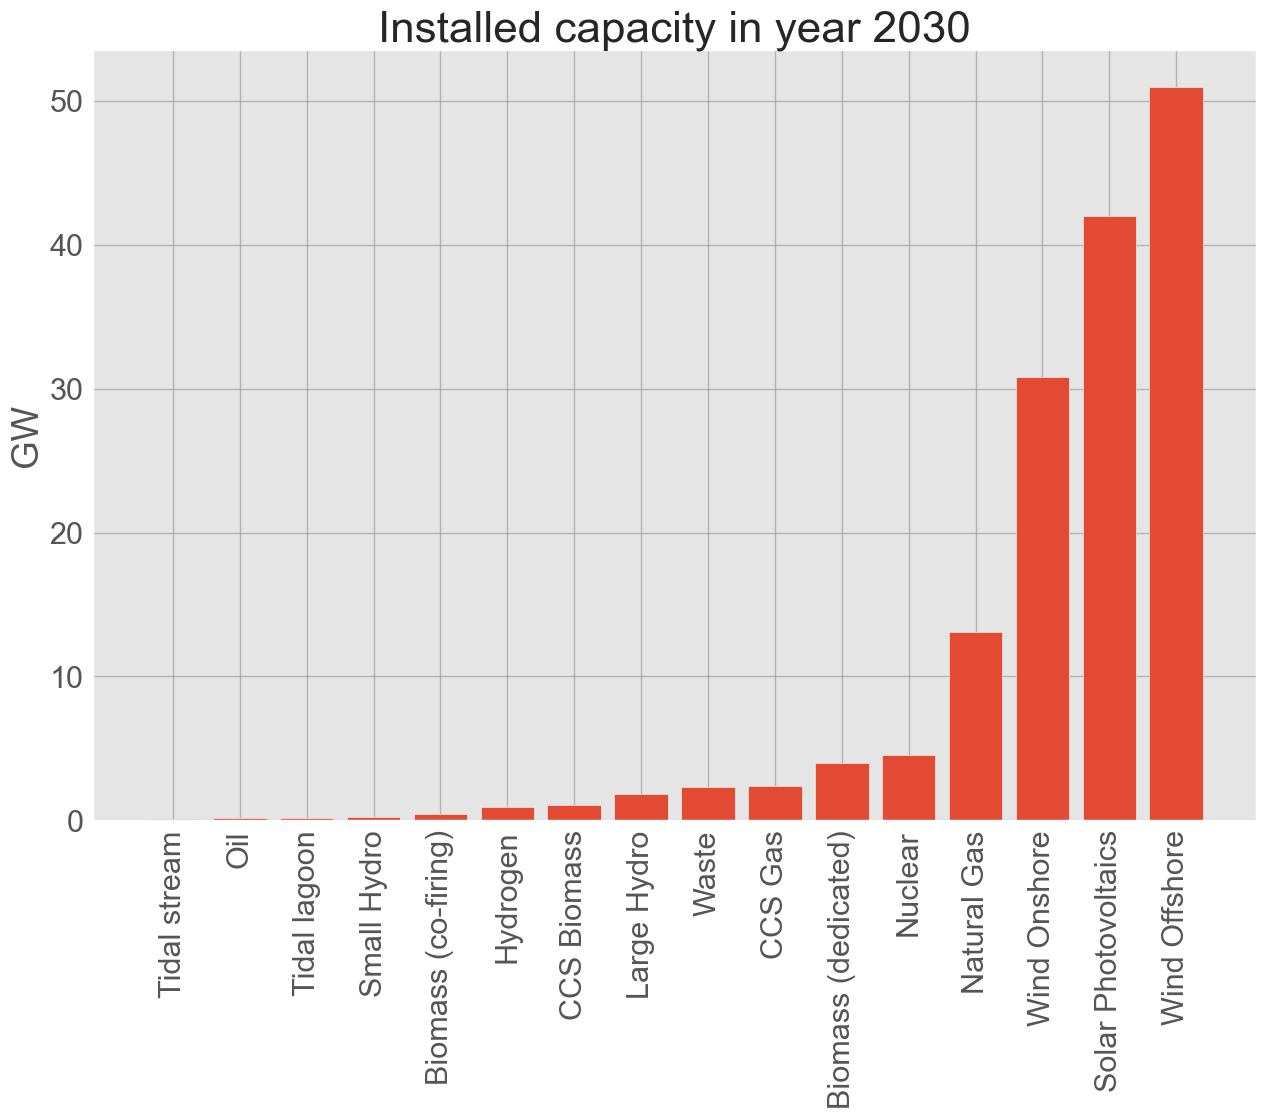

In [25]:
generators_p_nom = df_generators.p_nom.groupby(df_generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop("Unmet Load", inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({"font.size": 22})
# bar chart
plt.figure(figsize=(15,10))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel("GW")
plt.grid(color="grey", linewidth=1, axis="both", alpha=0.5)
plt.title("Installed capacity in year " + str(year))
plt.show()

In [26]:
generators_p_nom.index

Index(['Tidal stream', 'Oil', 'Tidal lagoon', 'Small Hydro',
       'Biomass (co-firing)', 'Hydrogen', 'CCS Biomass', 'Large Hydro',
       'Waste', 'CCS Gas', 'Biomass (dedicated)', 'Nuclear', 'Natural Gas',
       'Wind Onshore', 'Solar Photovoltaics', 'Wind Offshore'],
      dtype='object', name='carrier')

In [32]:
solar_cost: float = 0.00
offshore_cost: float = 0.00
onshore_cost: float = 0.00
biomass_cost: float = 0.00
ccgt_cost: float = 0.00

for gen_tech in generators_p_nom.index:
    if gen_tech == "Solar Photovoltaics":
        for key, value in PV_investment.items():
            solar_cost += value * generators_p_nom["Solar Photovoltaics"]

    if gen_tech == "Wind Offshore":
        for key, value in wind_offshore_investment.items():
            offshore_cost += value * generators_p_nom["Wind Offshore"]

    if gen_tech == "Wind Onshore":
        for key, value in wind_onshore_investment.items():
            onshore_cost += value * generators_p_nom["Wind Onshore"]

    if gen_tech == "Biomass (dedicated)":
        for key, value in biomass_investment.items():
            biomass_cost += value * generators_p_nom["Biomass (dedicated)"]

    if gen_tech == "Natural Gas":
        for key, value in ccgt_investment.items():
            ccgt_cost += value * generators_p_nom["Natural Gas"]

solar_cost *= 1.20
offshore_cost *= 1.20
onshore_cost *= 1.20
biomass_cost *= 1.20
ccgt_cost *= 1.20

print(
    f"{"Solar Cost":<15}{"|":^1}{solar_cost/10**6:>10.2f} {u"M\N{POUND SIGN}":<3} \n"
    f"{"Wind Offshore":<15}{"|":^1}{offshore_cost/10**6:>10.2f} {u"M\N{POUND SIGN}":<3} \n"
    f"{"Wind Onshore":<15}{"|":^1}{onshore_cost/10**6:>10.2f} {u"M\N{POUND SIGN}":<3} \n"
    f"{"Biomass":<15}{"|":^1}{biomass_cost/10**6:>10.2f} {u"M\N{POUND SIGN}":<3} \n"
    f"{"CCGT":<15}{"|":^1}{ccgt_cost/10**6:>10.2f} {u"M\N{POUND SIGN}":<3}"
)

Solar Cost     |  15118.64 M£  
Wind Offshore  |   2384.34 M£  
Wind Onshore   |  49910.36 M£  
Biomass        |  47882.85 M£  
CCGT           |  13483.45 M£ 


## Neso Data Further Flex

In [41]:
gen_data: dict[str, float] = {
    "Solar Photovoltaics": 47.4 * 10**3,  # MW
    "Wind Offshore": 50.6 * 10**3,        # MW
    "Wind Onshore": 27.3 * 10**3,         # MW
    "Biomass (dedicated)": 4.0 * 10**3,   # MW
    "Natural Gas": 35.0 * 10**3,          # MW
    "Nuclear": 3.5 * 10**3,               # MW
    "Hydrogen": 0.3 * 10**3,              # MW
}

df_neso_ff = pd.DataFrame(list(gen_data.items()), columns = ["Technology", "Capacity [MW]"].set_index("Technology"))
df_neso_ff

AttributeError: 'list' object has no attribute 'set_index'